In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os import path

## 1. 

In [2]:
texts = []
labels = []

for filename in [ path.join('sentiment labelled sentences', fn) for fn in 
                 [ 'amazon_cells_labelled.txt', 'imdb_labelled.txt', 'yelp_labelled.txt' ] ]:
    with open(filename) as f:
        for line in f:
            text, label = line.rstrip().split('\t')
            texts.append(text)
            labels.append(int(label))

nplabels = np.asarray(labels)

In [3]:
len(texts), len(nplabels)

(3000, 3000)

In [4]:
texts[:3], labels[:3]

(['So there is no way for me to plug it in here in the US unless I go by a converter.',
  'Good case, Excellent value.',
  'Great for the jawbone.'],
 [0, 1, 1])

## 2.

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

### 2.1 _TF-IDF features_

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [7]:
vectorizer = TfidfVectorizer()
sparse_matrix = vectorizer.fit_transform(texts)

### 2.2 _t-SNE visualization_

In [8]:
from mlxtend.preprocessing import DenseTransformer
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline

In [9]:
%%time

tsne = Pipeline(
[
    ('dense', DenseTransformer()),
    ('tsne', TSNE(n_components=2))
])

X_embedded = tsne.fit_transform(sparse_matrix)

Wall time: 3min 24s


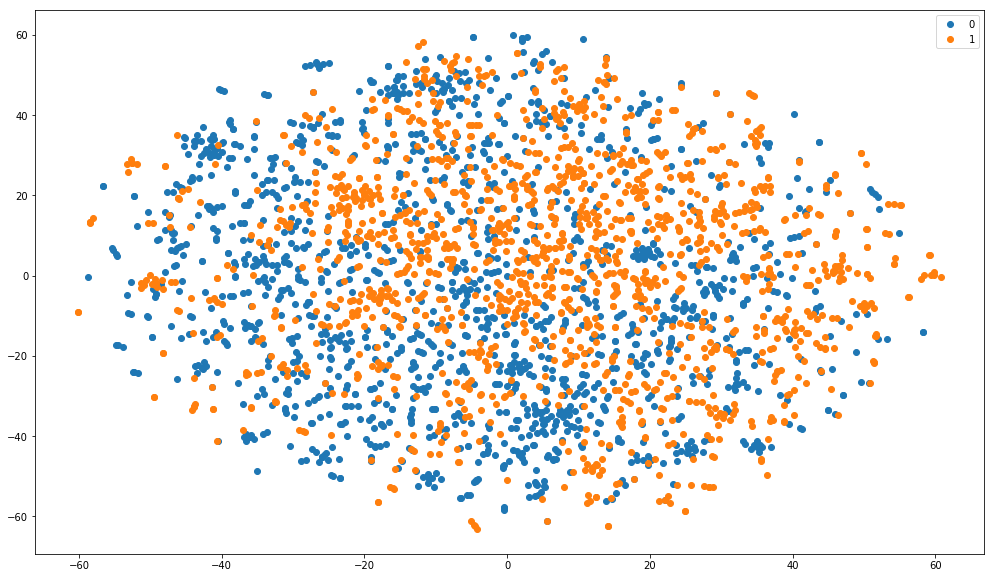

In [10]:
plt.figure(figsize=(17,10))

for u in sorted(np.unique(nplabels)):
    ix = np.argwhere(nplabels == u).squeeze()
    plt.plot(X_embedded[ix, 0], X_embedded[ix, 1], 'o', label='{}'.format(u))

plt.legend();

## 3. _SVC_

In [11]:
from sklearn.svm import SVC

In [12]:
X_emb_train, X_emb_test, X_train, X_test, y_train, y_test = \
    train_test_split(X_embedded, sparse_matrix, nplabels, train_size=0.8)

In [13]:
model = Pipeline(
[
    ('dense', DenseTransformer()),
    ('svm', SVC(kernel='linear'))
])

In [14]:
model.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('dense', DenseTransformer(return_copy=True)), ('svm', SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))])

In [15]:
y_pred = model.predict(X_test)

In [16]:
accuracy_score(y_test, y_pred)

0.8533333333333334

## 4.

In [17]:
svm = model.steps[1][1]

In [18]:
feature_importances = list(sorted(zip(vectorizer.get_feature_names(), svm.coef_.squeeze()), key=lambda x: -abs(x[1])))
pd.DataFrame(feature_importances, columns=['feature_name', 'feature_importance'])[:12]

,feature_name,feature_importance
0,not,-4.282314
1,great,3.794948
2,bad,-2.986867
3,good,2.918549
4,worst,-2.523874
5,best,2.479944
6,nice,2.406780
7,love,2.356941
8,delicious,2.228145
9,poor,-2.145948


## 5.

### 5.1 _Cross-validation_ 

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
model = Pipeline(
[
    ('dense', DenseTransformer()),
    ('svm', SVC())
])

svc_grid_params = {
    'svm__C' : [0.1, 0.5, 1.0, 10., 100.],
    'svm__kernel' : ['linear', 'rbf']
}

In [21]:
%%time

gs = GridSearchCV(model, svc_grid_params, scoring='accuracy', cv=5, n_jobs=8)
gs.fit(X_train, y_train)

Wall time: 22min 22s


In [23]:
gs.best_estimator_.steps[1][1]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [24]:
y_pred = gs.best_estimator_.predict(X_test)

print('[SVC] accuracy for best (train): {:.5f}'.format(gs.best_score_))
print('[SVC] accuracy for best (test): {:.5f}'.format(accuracy_score(y_pred, y_test)))
print('*' * 40)

[SVC] accuracy for best (train): 0.81167
[SVC] accuracy for best (test): 0.85333
****************************************


_То есть, фактически, параметры по-умолчанию оказались оптимальными, и можно было не запускать кросс-валидацию на 20 мин.)_.

### 5.2 _Learning curve_

...

?? *(https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html)*

## 6. 

_Сравним с логистической регрессией_.

In [25]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

In [26]:
%%time

model = Pipeline(
[
    ('dense', DenseTransformer()),
    ('regressor', LogisticRegressionCV(Cs=[0.1, 0.5, 1.0, 10., 100.], scoring='accuracy', cv=5))
])

model.fit(X_train, y_train);

Wall time: 15 s


In [27]:
y_pred = model.predict(X_test)

print('[LogR] accuracy for best (test): {:.5f}'.format(accuracy_score(y_pred, y_test)))
print('*' * 40)

[LogR] accuracy for best (test): 0.85667
****************************************


_То есть результат сопоставимый_.

## 7. _t-SNE_

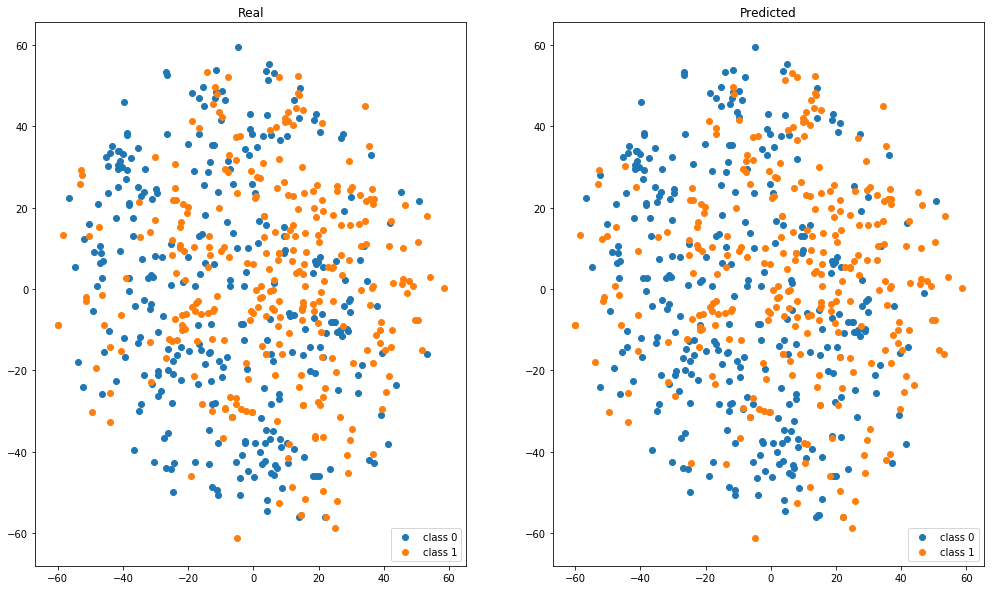

In [28]:
def plot_real_vs_predicted(X, y_test, y_pred):
    plt.figure(figsize=(17,10))
    
    def subplot(nrc, title, X, y):
        plt.subplot(nrc)
        plt.title(title)
        for u in sorted(np.unique(y)):
            ix = np.argwhere(y == u).squeeze()
            plt.scatter(X[ix, 0], X[ix, 1], label='class {}'.format(u))
        plt.legend(loc=4)
        
    subplot(121, 'Real', X_emb_test, y_test)
    subplot(122, 'Predicted', X_emb_test, y_pred)
    
plot_real_vs_predicted(X_emb_test, y_test, y_pred);